In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sb
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
%%time
df = pd.read_csv('raw_push_stat_2022_01_13_.gz', compression='gzip', header=0, sep=';',
                 dtype={
                     'user_id': str,
                     'content_id': str,
                     'push_opened': np.int8,
                     'content_type': str
                 },
                 parse_dates=['push_time', 'push_opened_time', 'create_at'])
df = df.drop_duplicates()

CPU times: user 17 s, sys: 1.58 s, total: 18.6 s
Wall time: 18.7 s


## Информация по данным

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2211058 entries, 0 to 3758798
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_id           object        
 1   content_id        object        
 2   push_opened       int8          
 3   push_time         datetime64[ns]
 4   push_opened_time  datetime64[ns]
 5   create_at         datetime64[ns]
 6   content_type      object        
dtypes: datetime64[ns](3), int8(1), object(3)
memory usage: 120.2+ MB


In [4]:
df[(df.push_opened == 1) & (df.push_opened_time != df.push_time)].shape[0] / df.shape[0]

0.05129761408339356

Особенности заполнения данных

Если пуш не был открыт, то ```push_opened_time == push_time```, но есть исключения у ~5.1% \
Колонка ```create_at``` - время создания ```content_id```

In [5]:
tt = df.content_type.value_counts()
tt1 = df[df.push_opened == 1].content_type.value_counts()
pd.DataFrame(data={
    "num_target": tt1,
    "num_cases": tt,
    "proportion_target": tt1 / tt
}).sort_values(by="num_cases", ascending=False)

,num_target,num_cases,proportion_target
pic,113328.0,2210346,0.051272
caption,95.0,703,0.135135
video_clip_user,2.0,8,0.250000
gif,NaN,1,NaN


In [6]:
df["push_day"] = df["push_time"].dt.date

In [7]:
df[df.push_day == pd.to_datetime("2021-12-14")].content_type.value_counts()

pic                735198
caption               158
video_clip_user         3
gif                     1
Name: content_type, dtype: int64

Набор данных искусственный и лучше всего просто убрать из обучающей выборки малочисленные content_type. Тем более что ```content_type == 'gif'``` только в последний день

In [8]:
df = df[~df.content_type.isin(["gif", "video_clip_user"])]

In [9]:
df["push_day"].value_counts().sort_index()

2021-12-12    740375
2021-12-13    735318
2021-12-14    735356
Name: push_day, dtype: int64

In [10]:
df.shape

(2211049, 8)

In [11]:
df["push_day"] = df["push_time"].dt.date
#Положительные классы - час открытия пуша, отрицательные классы - час отправки пуша
df["hour"] = np.where(df.push_opened == 1, df["push_opened_time"].dt.hour, df["push_time"].dt.hour)

! Нужно будет не забыть в задаче рекомендации избавиться от повторных вариантов user - hour - push_opened. Если пользователь хотя бы раз открывал пуш, то это успех

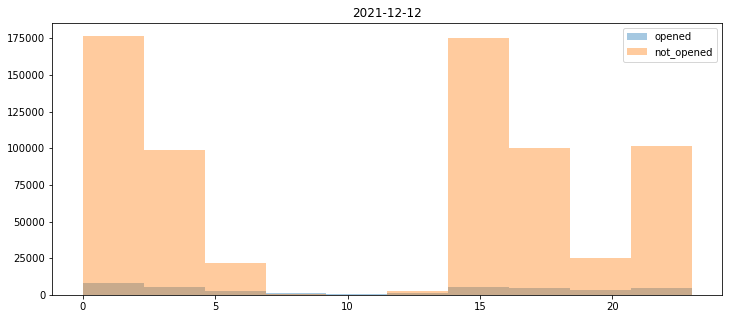

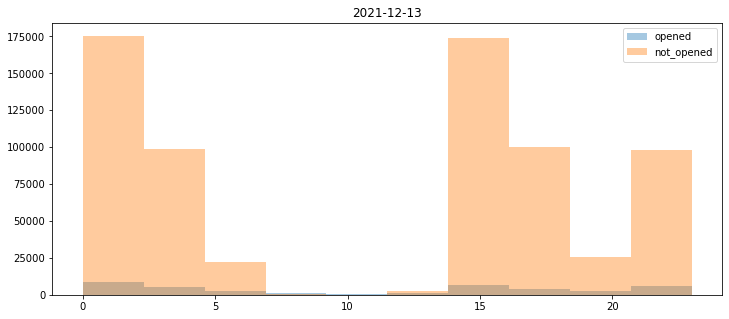

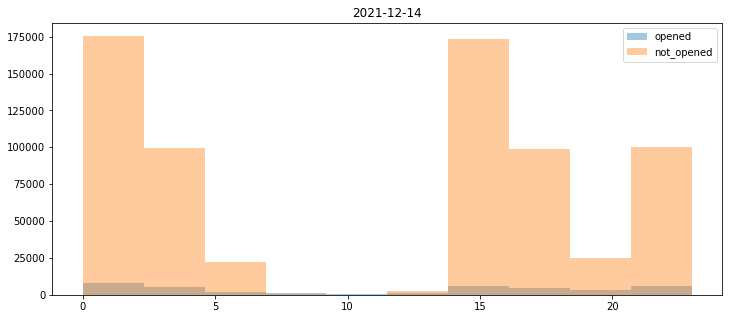

In [12]:
for d in df["push_day"].unique():
    curr = df[df.push_day == d]
    plt.figure(figsize=(12, 5));
    plt.title(d)
    plt.hist(curr[curr.push_opened == 1]["hour"], alpha=0.4, label='opened')
    plt.hist(curr[curr.push_opened == 0]["hour"], alpha=0.4, label='not_opened')
    plt.legend()
    plt.show()

In [13]:
#процент открытия пушей по часам
pd.DataFrame(data={
    "num_classes": df.hour.value_counts(),
    "num_cases": df[df.push_opened == 1].hour.value_counts(),
    "proportion_target": df[df.push_opened == 1].hour.value_counts() / df.hour.value_counts()
}).sort_values(by="proportion_target", ascending=False)

,num_classes,num_cases,proportion_target
12,1279,1261,0.985927
10,802,789,0.983791
9,764,749,0.980366
11,1165,1137,0.975966
8,1112,856,0.769784
7,2652,1412,0.532428
13,10353,2167,0.209311
3,38135,5797,0.152013
1,37552,5462,0.145452
5,28630,4007,0.139958


__Выводы__:

* В датасете представлены данные за 3 дня, логично будет делать тестовую выборку по последнему дню
* Количество примеров по дням примерно одинаково
* Убрала малочисленные типы контентов
* Ввела переменную target - час открытия пуша, отрицательные классы - час отправки пуша
* Гистограммы по часам открытия и по дням примерно одинаково => имеют схожее распределение
* Самые "открываемые" часы - 7, 8, 9, 10, 11, 12, но они же и самые малочисленные

## Проверка гипотезы

Сейчас каждый пользователь получает фиксированное количество пушей - 7 в день. Продуктовая гипотеза: для некоторых пользователей это слишком часто, а если слишком часто отправлять пуши пользователю, он перестанет переходить в приложение по пушу и уйдёт в отток - отток это плохо, мы такого допускать не хотим

```H_0``` - 7 пушей в день приводит к оттоку \
```H_A``` - иначе

In [14]:
gr = df.groupby(["user_id", "push_day"]).content_id.count()
gr = gr.reset_index()

In [15]:
gr.head()

,user_id,push_day,content_id
0,0001NZ0,2021-12-14,1
1,0002KP2,2021-12-12,1
2,0002KP2,2021-12-13,1
3,0002KP2,2021-12-14,1
4,0004ZD0,2021-12-12,3


In [16]:
gr[gr.content_id == 7]

,user_id,push_day,content_id
1393833,U39JK0R,2021-12-13,7


Всего 1 кейс с отправкой именно 7 пушей в день. Изменим гипотезу, 4 и больше пушей приводят в отток\
```H_0``` - пользователи с 4 и больше пушей в день чаще оттекают \
```H_A``` - иначе

In [17]:
tgr = gr[gr.content_id >= 4][["user_id", "push_day"]]

In [18]:
tgr.shape

(7783, 2)

In [19]:
tgr = tgr.merge(df, on=["user_id"])

In [20]:
tgr.shape

(41926, 10)

In [21]:
#Группа 0 - пользователи, кто получил в предыдущие дни 4 и больше пушей
group_0 = tgr[tgr.push_day_y > tgr.push_day_x].groupby(["user_id", "push_day_x"])\
.apply(lambda s: s.push_opened.sum()/s.push_opened.count())

In [22]:
stats_gr_0 = group_0.groupby("user_id").mean().reset_index()

In [23]:
#Группа 1 - те же самые пользователи из группы 0, но в дни, где они получают меньше 4 пушей
group_1 = tgr[tgr.push_day_y <= tgr.push_day_x].groupby(["user_id", "push_day_x"])\
.apply(lambda s: s.push_opened.sum()/s.push_opened.count())

In [24]:
stats_gr_1 = group_1.groupby("user_id").mean().reset_index()

In [25]:
stat_df = stats_gr_0.merge(stats_gr_1, on=["user_id"])

In [26]:
stat_df["0_x"].mean(), stat_df["0_y"].mean()

(0.05811348408710219, 0.05713869333137546)

In [27]:
from scipy import stats
stats.ttest_ind(stat_df["0_x"], stat_df["0_y"])

Ttest_indResult(statistic=0.20822967349587237, pvalue=0.835056301666354)

In [28]:
%%time
#Группа 2 - клиенты, кто не получал 4 и больше пушей в день
ugr = gr[gr.content_id < 4][["user_id", "push_day"]]
ugr = ugr.merge(df[["user_id", "push_day", "push_opened"]], on=["user_id", "push_day"])
group_2 = ugr.groupby(["user_id", "push_day"]).apply(lambda s: s.push_opened.sum()/s.push_opened.count())

CPU times: user 2min 52s, sys: 1.39 s, total: 2min 53s
Wall time: 2min 54s


In [29]:
stats.ttest_ind(stat_df["0_x"], group_2)

Ttest_indResult(statistic=1.844742879038277, pvalue=0.06507512786413651)

In [30]:
stats.ttest_ind(stat_df["0_y"], group_2)

Ttest_indResult(statistic=1.5826192542958097, pvalue=0.1135084623883084)

Заметим, что ```p_value > 0.05``` во всех случаях => нет оснований опровергнуть гипотезу о 4 пушей и больше в день. Значит что число пушей 4 и больше не меняет хакрактер открытия пушей

## Генерация фичей

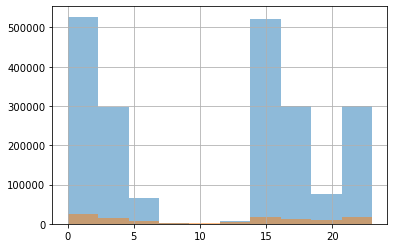

In [31]:
df[df.push_opened == 0]["hour"].hist(alpha=0.5)
df[df.push_opened == 1]["hour"].hist(alpha=0.5)

In [32]:
#Время жизни пуша ко дню предсказания
df["time_living_push"] = (df["push_time"].dt.date - df["create_at"].dt.date).dt.days

In [33]:
df = df.sort_values(by="push_time").reset_index(drop=True)

In [34]:
%%time
gr = df.groupby(["user_id", "push_day"]).agg({"push_opened": ["sum", "count"]})
gr = gr.reset_index().droplevel(level=1, axis=1)
gr.columns = ["user_id", "push_day", "push_opened_sum", "push_opened_count"]

CPU times: user 5.49 s, sys: 234 ms, total: 5.72 s
Wall time: 5.73 s


In [35]:
%%time
#Число открытых пушей за предыдущий день
gr["num_opened_push_day_before"] = gr.groupby("user_id").push_opened_sum.shift(1).fillna(0)
#Флаг открытия пуша за предыдущий день
gr["has_opened_push_day_before"] = np.where(gr["num_opened_push_day_before"] > 0, 1, 0)
#Средняя доля открытия пушей в день
gr["avg_ratio_opened_push_in_day"] = gr.groupby("user_id").push_opened_sum.shift(1).fillna(0) /\
                                            gr.groupby("user_id").push_opened_count.shift(1).fillna(0)

CPU times: user 7.09 s, sys: 377 ms, total: 7.46 s
Wall time: 5.99 s


In [36]:
%%time
gr = gr.drop(columns=["push_opened_sum", "push_opened_count"])
gr = gr.fillna(0)
df = df.merge(gr, on=["user_id", "push_day"], how="left")

CPU times: user 4.05 s, sys: 383 ms, total: 4.44 s
Wall time: 4.44 s


In [37]:
#One-hot encoding content type
new_df = pd.get_dummies(df, columns=['content_type'])

In [38]:
tt = new_df[new_df.push_opened == 1]\
.groupby(["user_id", "push_day"], as_index=False).hour.last()\
.rename(columns={"hour": "last_opened_hour"})

tt["last_opened_hour_before"] = tt\
.groupby(["user_id"], as_index=False).last_opened_hour.shift(-1)

new_df = new_df.merge(tt.drop(columns="last_opened_hour"), on=["user_id", "push_day"], how='left')
#Последний час, в который пользователь открыл пуш
new_df.last_opened_hour_before = new_df.last_opened_hour_before.fillna(-1).astype(int)

In [39]:
#Labelencoder пользователей и айтемов, где айтемы будут - час отправки пуша
new_df["uid"] = new_df["user_id"].astype("category")
new_df["uid"] = new_df["uid"].cat.codes
new_df["iid"] = new_df["content_id"].astype("category")
new_df["iid"] = new_df["iid"].cat.codes

Еще идеи фичей:
* День недели, месяц
* Тип дня недели - будни или выходные
* Праздничные/не праздничные дни
* Сколько дней назад было последнее открытие пуша
* Фичи по пользователям
* Фичи по пушам

## Отбор признаков

Так как фичи придумала сама, то вероятнее всего они коррелируют между собой.\
Отберем фичи: удалим то, что с корреляцией больше 0.9 и оставим из них только те, что больше всего влияют на результат (с большим ```information value```)

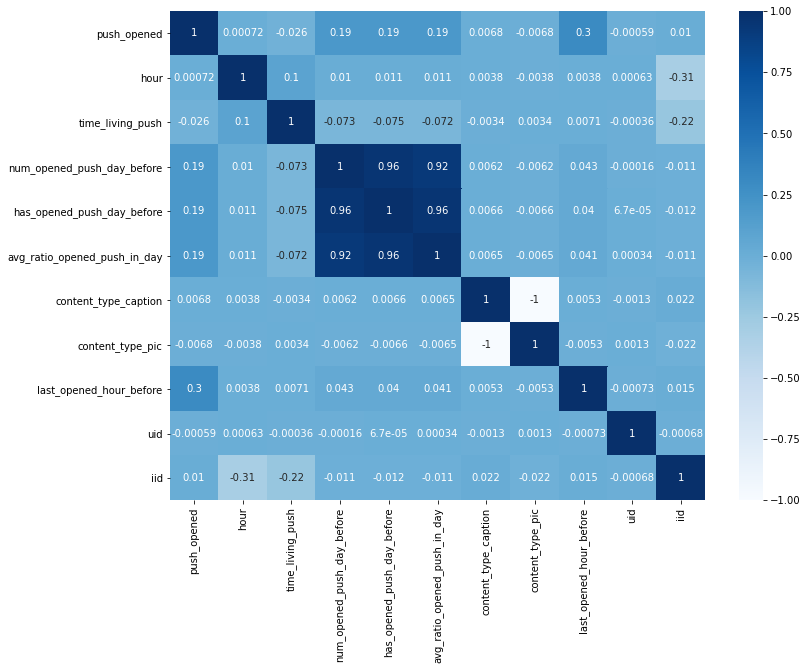

In [40]:
plt.figure(figsize=(12, 9))
sb.heatmap(new_df.corr(), cmap="Blues", annot=True)

In [41]:
def calc_iv(df, feature, target, pr=0) -> float:
    """
    Calculates information value
    :param df: pandas.DataFrame - input data
    :param feature: str - name of feature column
    :param target: str - name of target column
    :param pr: bool - if True than result dataframe will be printed
    
    :return: float - information value
    """

    lst = []

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], df[(df[feature] == val) & (df[target] == 1)].count()[feature]])

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])
    data = data[data['Bad'] > 0]

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data['IV'] = (data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)

    if pr == 1:
        print(data)

    return data['IV'].values[0]

In [42]:
calc_iv(new_df, "num_opened_push_day_before", "push_opened"), calc_iv(new_df, "num_opened_push_day_before", "hour")

(0.3145522204125395, 0.032542167264413356)

In [43]:
calc_iv(new_df, "has_opened_push_day_before", "push_opened"), calc_iv(new_df, "has_opened_push_day_before", "hour")

(0.3098380801426911, 0.03235320396376685)

In [44]:
calc_iv(new_df, "avg_ratio_opened_push_in_day", "push_opened"), calc_iv(new_df, "avg_ratio_opened_push_in_day", "hour")

(inf, 0.032573229366570526)

Оставим фичу ```num_opened_push_day_before```.\
Признаки ```content_type_caption, content_type_gif, content_type_pic``` - бинарные, можно сделать отбор по корреляции Крамера, а можно просто использовать как категориальные в catboost (Спойлер: как некатегориальные получилось лучше)

## Метрика

Закрепим метрику для сравнения наших моделей.
Задача бинарной классификации при условии фичи часа, стандартные метрики для бинарных классификаций ```precision, recall, roc-auc```

## Валидация

Данные разобьем на обучение и валидацию по времени. У нас есть 3 дня, возьмем первые 2 дня как обучение и третий день - валидация.\
В валидации оставим только те примеры, у кого было выполнено условие ```push_opened == 1```

## Построение моделей

### Catboost как бинарная классификация

In [45]:
from catboost import Pool, CatBoostClassifier
drop_cols = [
    'push_time', 'push_opened_time', 'time_living_push',
    'create_at', 'push_day', 'user_id', 'content_id', 'iid',
    'has_opened_push_day_before', 'avg_ratio_opened_push_in_day',
    'last_opened_hour_before'
]

train_data = new_df[(new_df.push_day < pd.to_datetime('2021-12-14'))]\
                .drop(columns=drop_cols)\
                .drop_duplicates()

#Валидируемся только на правильных ответах
eval_data = new_df[(new_df.push_day == pd.to_datetime('2021-12-14'))]\
                .drop(columns=drop_cols)\
                .drop_duplicates()

cat_features = ['uid', 'hour']

train_dataset = Pool(data=train_data.drop(columns="push_opened"),
                     label=train_data["push_opened"],
                     cat_features=cat_features)

eval_dataset = Pool(data=eval_data.drop(columns="push_opened"),
                    label=eval_data["push_opened"],
                    cat_features=cat_features)

model = CatBoostClassifier(iterations=1000, learning_rate=0.001, l2_leaf_reg=2,
                           depth=3, custom_loss=['Logloss', 'AUC:hints=skip_train~false'], 
                           task_type="CPU", devices='0:1', early_stopping_rounds=100,
                           eval_metric='AUC', use_best_model=True, random_seed=13)

model.fit(train_dataset, eval_set=eval_dataset)

0:	learn: 0.6491856	test: 0.7069437	best: 0.7069437 (0)	total: 801ms	remaining: 13m 20s
1:	learn: 0.6865145	test: 0.7411786	best: 0.7411786 (1)	total: 1.45s	remaining: 12m 3s
2:	learn: 0.6866046	test: 0.7411786	best: 0.7411786 (1)	total: 1.97s	remaining: 10m 55s
3:	learn: 0.6866142	test: 0.7411877	best: 0.7411877 (3)	total: 2.24s	remaining: 9m 17s
4:	learn: 0.6866129	test: 0.7411877	best: 0.7411877 (3)	total: 2.66s	remaining: 8m 50s
5:	learn: 0.6866175	test: 0.7411877	best: 0.7411877 (3)	total: 2.89s	remaining: 7m 59s
6:	learn: 0.6866346	test: 0.7413087	best: 0.7413087 (6)	total: 3.16s	remaining: 7m 28s
7:	learn: 0.6866503	test: 0.7413087	best: 0.7413087 (6)	total: 3.37s	remaining: 6m 58s
8:	learn: 0.6866507	test: 0.7413087	best: 0.7413087 (6)	total: 3.58s	remaining: 6m 34s
9:	learn: 0.6866510	test: 0.7413087	best: 0.7413087 (6)	total: 3.86s	remaining: 6m 21s
10:	learn: 0.6866509	test: 0.7413087	best: 0.7413087 (6)	total: 4.11s	remaining: 6m 9s
11:	learn: 0.6866507	test: 0.7413087	best

94:	learn: 0.6869399	test: 0.7414782	best: 0.7414782 (63)	total: 23.4s	remaining: 3m 42s
95:	learn: 0.6869426	test: 0.7414955	best: 0.7414955 (95)	total: 23.6s	remaining: 3m 42s
96:	learn: 0.6869426	test: 0.7414955	best: 0.7414955 (95)	total: 23.8s	remaining: 3m 41s
97:	learn: 0.6869426	test: 0.7414955	best: 0.7414955 (95)	total: 24s	remaining: 3m 40s
98:	learn: 0.6869425	test: 0.7414955	best: 0.7414955 (95)	total: 24.2s	remaining: 3m 40s
99:	learn: 0.6869425	test: 0.7414955	best: 0.7414955 (95)	total: 24.4s	remaining: 3m 39s
100:	learn: 0.6869425	test: 0.7414955	best: 0.7414955 (95)	total: 24.6s	remaining: 3m 39s
101:	learn: 0.6869425	test: 0.7414955	best: 0.7414955 (95)	total: 24.8s	remaining: 3m 38s
102:	learn: 0.6869425	test: 0.7414955	best: 0.7414955 (95)	total: 25.1s	remaining: 3m 38s
103:	learn: 0.6869425	test: 0.7414955	best: 0.7414955 (95)	total: 25.3s	remaining: 3m 37s
104:	learn: 0.6869426	test: 0.7414955	best: 0.7414955 (95)	total: 25.5s	remaining: 3m 37s
105:	learn: 0.6869

185:	learn: 0.6894771	test: 0.7448046	best: 0.7448046 (168)	total: 43.6s	remaining: 3m 10s
186:	learn: 0.6894771	test: 0.7448046	best: 0.7448046 (168)	total: 43.9s	remaining: 3m 10s
187:	learn: 0.6894775	test: 0.7448082	best: 0.7448082 (187)	total: 44.1s	remaining: 3m 10s
188:	learn: 0.6894775	test: 0.7448082	best: 0.7448082 (187)	total: 44.3s	remaining: 3m 10s
189:	learn: 0.6894775	test: 0.7448082	best: 0.7448082 (187)	total: 44.6s	remaining: 3m 10s
190:	learn: 0.6896449	test: 0.7449569	best: 0.7449569 (190)	total: 44.9s	remaining: 3m 10s
191:	learn: 0.6899531	test: 0.7451212	best: 0.7451212 (191)	total: 45.2s	remaining: 3m 10s
192:	learn: 0.6899528	test: 0.7451212	best: 0.7451212 (191)	total: 45.5s	remaining: 3m 10s
193:	learn: 0.6899529	test: 0.7451212	best: 0.7451212 (191)	total: 45.8s	remaining: 3m 10s
194:	learn: 0.6899528	test: 0.7451212	best: 0.7451212 (191)	total: 46s	remaining: 3m 10s
195:	learn: 0.6899528	test: 0.7451212	best: 0.7451212 (191)	total: 46.3s	remaining: 3m 9s
19

276:	learn: 0.6899534	test: 0.7451178	best: 0.7451269 (225)	total: 1m 5s	remaining: 2m 50s
277:	learn: 0.6899535	test: 0.7451178	best: 0.7451269 (225)	total: 1m 5s	remaining: 2m 50s
278:	learn: 0.6899535	test: 0.7451178	best: 0.7451269 (225)	total: 1m 5s	remaining: 2m 50s
279:	learn: 0.6899534	test: 0.7451178	best: 0.7451269 (225)	total: 1m 6s	remaining: 2m 49s
280:	learn: 0.6899535	test: 0.7451178	best: 0.7451269 (225)	total: 1m 6s	remaining: 2m 49s
281:	learn: 0.6899535	test: 0.7451179	best: 0.7451269 (225)	total: 1m 6s	remaining: 2m 49s
282:	learn: 0.6899535	test: 0.7451179	best: 0.7451269 (225)	total: 1m 6s	remaining: 2m 48s
283:	learn: 0.6899535	test: 0.7451179	best: 0.7451269 (225)	total: 1m 6s	remaining: 2m 48s
284:	learn: 0.6899537	test: 0.7451178	best: 0.7451269 (225)	total: 1m 7s	remaining: 2m 48s
285:	learn: 0.6899535	test: 0.7451178	best: 0.7451269 (225)	total: 1m 7s	remaining: 2m 48s
286:	learn: 0.6899535	test: 0.7451178	best: 0.7451269 (225)	total: 1m 7s	remaining: 2m 48s

In [46]:
import gc
gc.collect()

42

In [47]:
pd.DataFrame(data={"labels": model.feature_names_, "imp": model.feature_importances_})\
.sort_values(by="imp", ascending=False)

,labels,imp
0,hour,79.929443
1,num_opened_push_day_before,19.877306
2,content_type_caption,0.191318
3,content_type_pic,0.001933
4,uid,0.000000


In [48]:
preds = model.predict_proba(eval_dataset)[:,1]

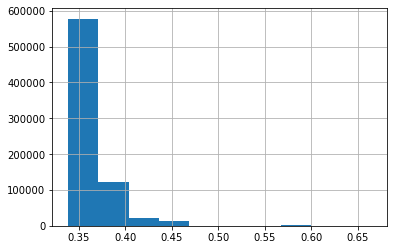

In [49]:
pd.Series(preds).hist()

In [50]:
from sklearn.metrics import precision_recall_fscore_support
threshold = 0.4
precision_recall_fscore_support(eval_data["push_opened"], preds > threshold, average='binary')

(0.3372213075871306, 0.3206761131454652, 0.3287406661860914, None)

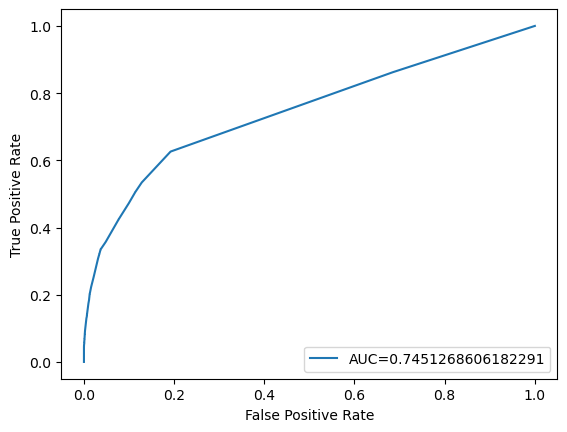

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(eval_data["push_opened"],  preds)
auc = roc_auc_score(eval_data["push_opened"],  preds)
#create ROC curve
plt.style.use('default');
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

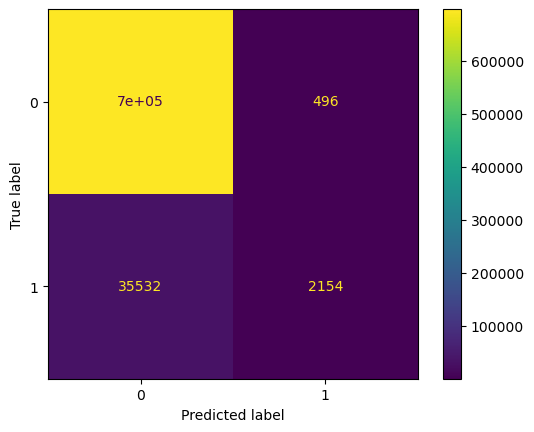

In [52]:
from sklearn.metrics import plot_confusion_matrix
plt.style.use('default');
plot_confusion_matrix(model, eval_data[model.feature_names_], eval_data["push_opened"]) 

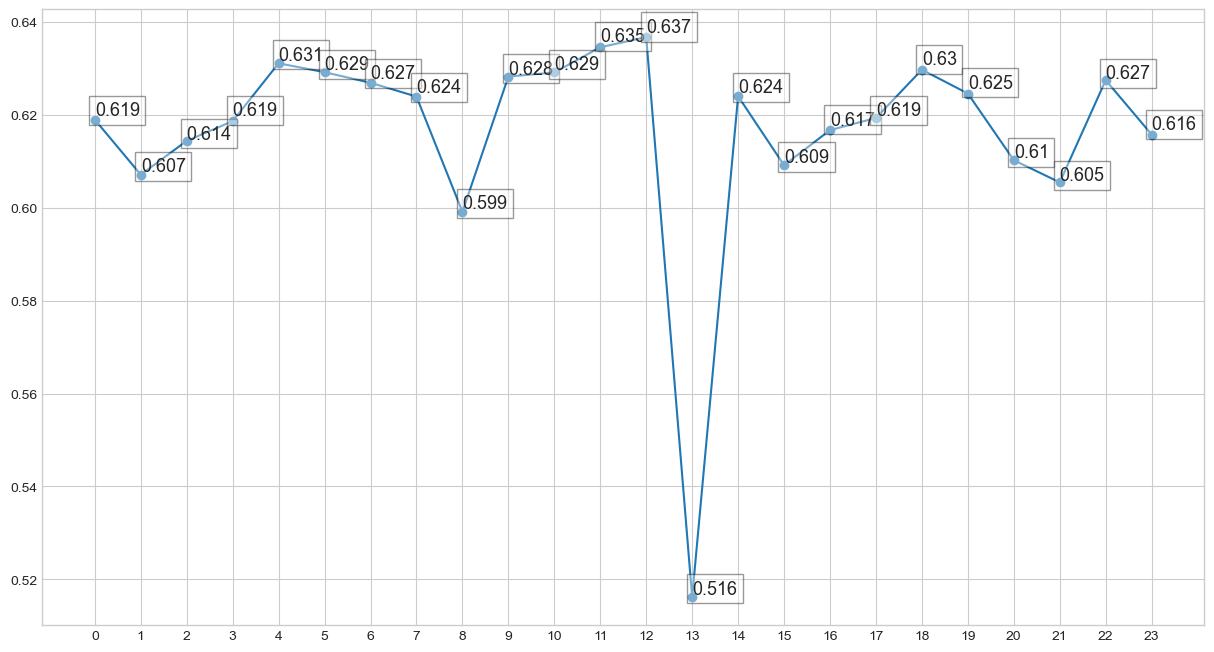

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score
rc_s = []
for t in new_df.hour.unique():
    pred_t = model.predict_proba(eval_data[eval_data.hour == t][model.feature_names_])[:,1]
    rc_s.append(roc_auc_score(eval_data[eval_data.hour == t].push_opened, pred_t))

tt = pd.DataFrame(data={
    "class": new_df.hour.unique(),
    "roc_auc": rc_s
}).sort_values(by="class").reset_index(drop=True)

plt.figure(figsize=(15, 8));
plt.style.use('seaborn-whitegrid');
plt.plot(tt["class"], tt["roc_auc"], '-o');
for a,b in zip(tt["class"], np.round(tt["roc_auc"], 3)): 
    plt.text(a, b, str(b), fontsize=13, va='bottom', \
             Bbox = dict(facecolor = 'white', alpha =.4))
plt.xticks(tt["class"]);

In [54]:
def get_top_1_recs(model, user):
    list_hours = np.arange(0, 24)
    res = []
    res.append(model.predict_proba(user)[:, 1][0])
    for h in range(1, 24):
        user[f"hour"] = h
        res.append(model.predict_proba(user)[:, 1][0])
    return np.array(res).argmax()

In [55]:
from tqdm.notebook import tqdm
res = []
for c in tqdm(range(1, 1000)):
    res.append(get_top_1_recs(model, eval_data.iloc[c-1:c][model.feature_names_]))

In [56]:
pd.Series(res).value_counts()

9    998
0      1
dtype: int64

In [57]:
from tqdm.notebook import tqdm
res = []
for c in tqdm(range(734292, 735292)):
    res.append(get_top_1_recs(model, eval_data.iloc[c-1:c][model.feature_names_]))

In [58]:
pd.Series(res).value_counts()

9    1000
dtype: int64

__Выводы__:

* ```content_id``` сильно влияет на таргет, как и ```time_living_push``` - были исключены из построения модели, из-за большого числа малочисленных вариантов конктреных контентов. ```last_opened_hour_before``` - не сильно докидывает качество, так как примеров слишком мало
* Самый популярный час, который выдает модель = 9
* Стоит укрупнять классы - 7, 8, 9, 10, 11, 12, чтобы добиться лучшего качества
* Для более разнообразной выдачи лучшего часа необходимо больше фичей
* Есть GPU реализация, что существенно ускорит ежедневное-еженедельное переобучение модели

### Catboost как задача ранжирования

In [59]:
drop_cols = [
    'push_time', 'push_opened_time', 
    'create_at', 'push_day', 'user_id', 'content_id',
    'has_opened_push_day_before', 'avg_ratio_opened_push_in_day',
    'last_opened_hour_before', 'time_living_push'
]
train = new_df[new_df.push_day < pd.to_datetime('2021-12-14')].sort_values(by="uid")\
        .drop(columns=drop_cols).drop_duplicates()
X_train = train.drop(columns="push_opened")
y_train = train.push_opened

test = new_df[new_df.push_day == pd.to_datetime('2021-12-14')].sort_values(by="uid")\
        .drop(columns=drop_cols).drop_duplicates()
X_test = test.drop(columns="push_opened")
y_test = test.push_opened

In [60]:
train_pool = Pool(
    data=X_train.drop(['uid'], axis=1),
    label=y_train,
    group_id=X_train['uid']
)


test_pool = Pool(
    data=X_test.drop(['uid'], axis=1),
    label=y_test,
    group_id=X_test['uid']
)

In [61]:
from catboost import Pool, CatBoostRanker

parameters = {
    'learning_rate': 0.03,
    'iterations': 1000,
    'custom_metric': ['PrecisionAt:top=1', 'RecallAt:top=1'],
    'l2_leaf_reg': 2,
    'early_stopping_rounds': 100,
    'verbose': False,
    'random_seed': 13,
}

model = CatBoostRanker(**parameters)
model.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [67]:
model.best_score_

{'learn': {'PrecisionAt:top=1': 0.0663606471599051,
  'RecallAt:top=1': 0.9852523372636237},
 'validation': {'PFound': 0.06041244475382261,
  'PrecisionAt:top=1': 0.05291366082365059,
  'RecallAt:top=1': 0.9882677264311543}}

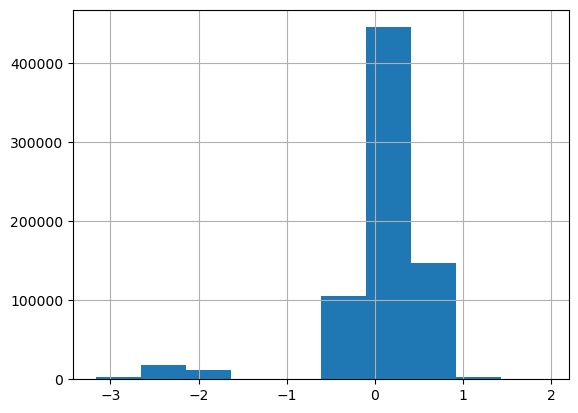

In [68]:
pd.Series(model.predict(test_pool)).hist()

In [69]:
from sklearn.metrics import precision_recall_fscore_support
threshold = 0.3
precision_recall_fscore_support(y_test, model.predict(test_pool) > threshold, average='binary')

(0.06313730360802335, 0.26945298420438885, 0.10230325716183172, None)

In [70]:
preds = model.predict(test_pool)

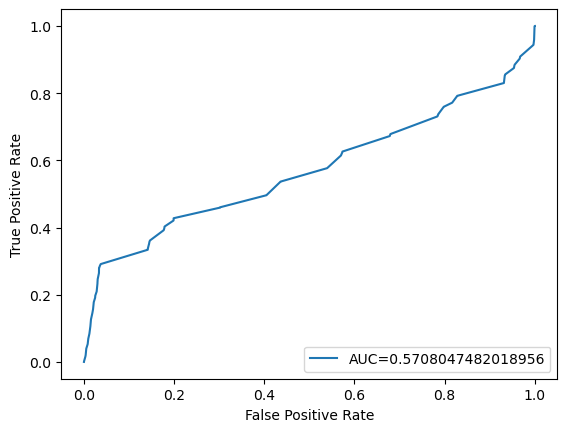

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test, 1 - preds)
auc = roc_auc_score(y_test, 1 - preds)
#create ROC curve
plt.style.use('default');
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

A special case: top-1 prediction
Someday you may face with a problem  you will need to predict the top one most relevant object for a given query.
For this purpose CatBoostRanker has a mode called QuerySoftMax.

Suppose our dataset contain a binary target: 1  mean best document for a query, 0  others.

In [72]:
drop_cols = [
    'push_time', 'push_opened_time', 
    'create_at', 'push_day', 'user_id', 'content_id',
    'has_opened_push_day_before', 'avg_ratio_opened_push_in_day',
    'last_opened_hour_before', 'time_living_push'
]
train = new_df[new_df.push_day < pd.to_datetime('2021-12-14')].sort_values(by="uid")\
        .drop(columns=drop_cols).drop_duplicates()
X_train = train[['push_opened', 'hour', 'uid']]
y_train = train.push_opened

test = new_df[new_df.push_day == pd.to_datetime('2021-12-14')].sort_values(by="uid")\
        .drop(columns=drop_cols).drop_duplicates()
X_test = test[['push_opened', 'hour', 'uid']]
y_test = test.push_opened

In [73]:
def create_weights(queries):
    query_set = np.unique(queries)
    query_weights = np.random.uniform(size=query_set.shape[0])
    weights = np.zeros(shape=queries.shape)
    
    for i, query_id in enumerate(query_set):
        weights[queries == query_id] = query_weights[i]
    
    return weights

In [74]:
%%time
train_pool = Pool(
    data=X_train.drop(columns='uid'),
    label=y_train,
    group_id=X_train['uid'],
    group_weight=create_weights(X_train['uid'])
)


test_pool = Pool(
    data=X_test.drop(columns='uid'),
    label=y_test,
    group_id=X_test['uid'],
    group_weight=create_weights(X_test['uid'])
)

CPU times: user 30min 1s, sys: 2min 33s, total: 32min 34s
Wall time: 12min 57s


In [75]:
from copy import deepcopy 

default_parameters = {
    'iterations': 500,
    'learning_rate': 0.01,
    'early_stopping_rounds': 80,
    'custom_metric': ['AverageGain:top=1'],
    'verbose': False,
    'random_seed': 0,
}

def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=test):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=True)
    
    return model

model = fit_model(
    'QuerySoftMax',
    additional_params={'custom_metric': ['PrecisionAt:top=1', 'RecallAt:top=1']},
    train_pool=train_pool,
    test_pool=test_pool
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

__Выводы__:

* Предлженный вариант ранжирования от разработчиков Catboost - обучается очень долго, требует много ресурсов. С конкретными данными QuerySoftMax не коррелирует с Precision и Recall.
* Catboost как задача ранжирования - ок, но хуже чем просто бинарная классификация

### Наивный байесовский классификатор

In [76]:
#One-hot hours
new_df = pd.get_dummies(new_df, columns=['hour'])

In [77]:
%%time
from sklearn.naive_bayes import BernoulliNB
drop_cols = [
    'push_time', 'push_opened_time', 'time_living_push',
    'create_at', 'push_day', 'user_id', 'push_opened', 'content_id',
    'num_opened_push_day_before', 'avg_ratio_opened_push_in_day',
    'last_opened_hour_before'
]
train = new_df[(new_df.push_day < pd.to_datetime('2021-12-14'))]
X_train = train.drop(columns=drop_cols)
y_train = train.push_opened

val = new_df[(new_df.push_day == pd.to_datetime('2021-12-14'))]
X_val = val.drop(columns=drop_cols).drop_duplicates()
y_val = val.loc[X_val.index].push_opened

nb_model = BernoulliNB(alpha=100)
nb_model.fit(X_train, y_train)

CPU times: user 6 s, sys: 777 ms, total: 6.77 s
Wall time: 6.84 s


BernoulliNB(alpha=100)

In [78]:
pd.DataFrame(data={"labels": X_train.columns, "imp": nb_model.coef_[0]})\
.sort_values(by="imp", ascending=False)

,labels,imp
3,uid,-0.001319
4,iid,-0.001319
2,content_type_pic,-0.002427
7,hour_2,-2.346505
0,has_opened_push_day_before,-2.367796
9,hour_4,-2.428535
5,hour_0,-2.497197
23,hour_18,-2.611544
21,hour_16,-2.655197
26,hour_21,-2.676035


In [79]:
preds = nb_model.predict_proba(X_val)[:,1]

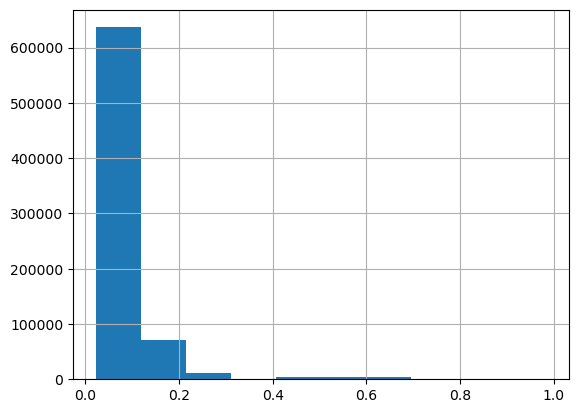

In [80]:
pd.Series(preds).hist()

In [81]:
from sklearn.metrics import precision_recall_fscore_support
threshold = 0.4
precision_recall_fscore_support(y_val, preds > threshold, average='binary')

(0.4644401570088484, 0.18501537156789993, 0.26461725072493986, None)

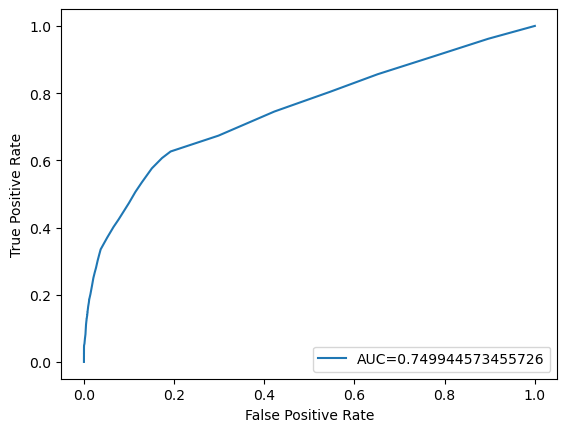

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_val,  preds)
auc = roc_auc_score(y_val,  preds)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

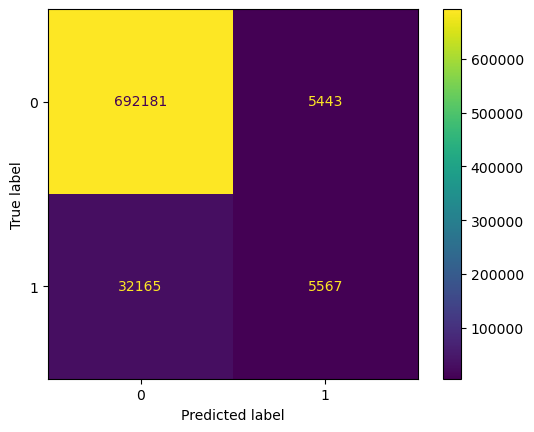

In [83]:
from sklearn.metrics import plot_confusion_matrix
plt.style.use('default');
plot_confusion_matrix(nb_model, X_val, y_val)

In [84]:
def get_top_1_recs(model, user):
    list_hours = np.arange(0, 24)
    res = []
    res.append(model.predict_proba(user)[:, 1][0])
    for h in range(1, 24):
        user[f"hour_{h}"] = 1
        user[f"hour_{h-1}"] = 0
        res.append(model.predict_proba(user)[:, 1][0])
    return np.array(res).argmax()

In [85]:
from tqdm.notebook import tqdm
res = []
for c in tqdm(range(1, 1000)):
    res.append(get_top_1_recs(nb_model, X_val.iloc[c-1:c]))

In [86]:
pd.Series(res).value_counts()

12    998
11      1
dtype: int64

In [87]:
from tqdm.notebook import tqdm
res = []
for c in tqdm(range(734292, 735292)):
    res.append(get_top_1_recs(nb_model, X_val.iloc[c-1:c]))

In [88]:
pd.Series(res).value_counts()

12    1000
dtype: int64

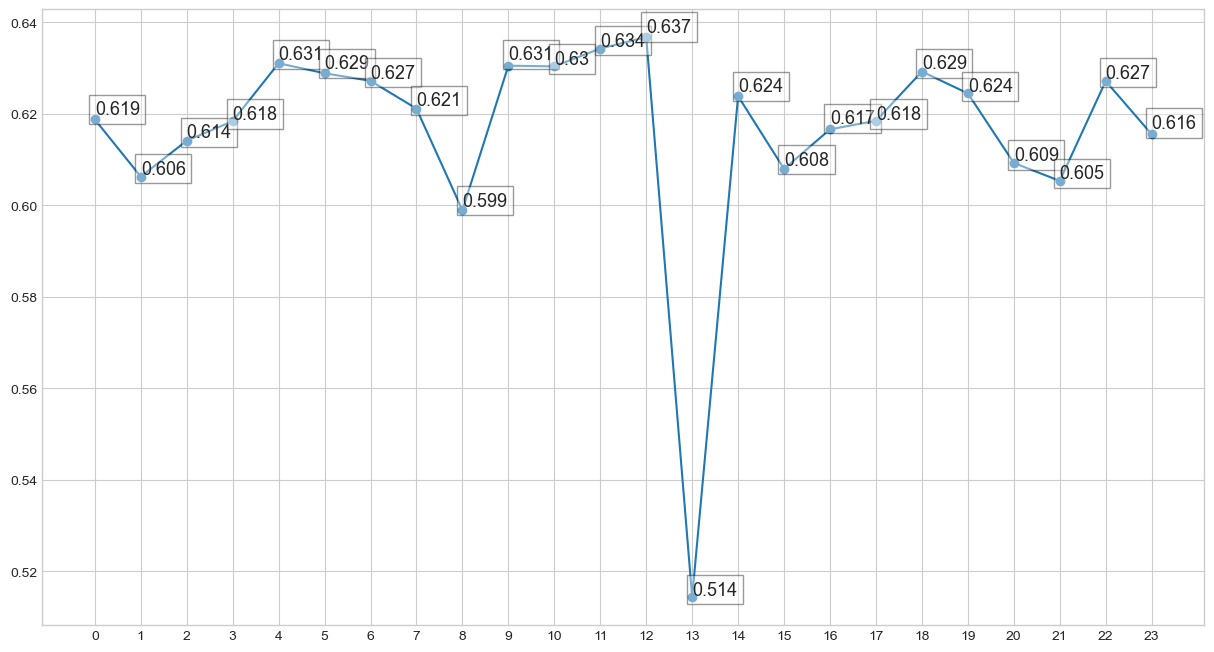

In [89]:
from sklearn.metrics import roc_curve, roc_auc_score
rc_s = []
for t in range(0, 24):
    curr = X_val[X_val[f"hour_{t}"] == 1]
    pred_t = nb_model.predict_proba(curr)[:,1]
    rc_s.append(roc_auc_score(y_val.loc[curr.index], pred_t))

tt = pd.DataFrame(data={
    "class": range(0, 24),
    "roc_auc": rc_s
}).sort_values(by="class").reset_index(drop=True)

plt.figure(figsize=(15, 8));
plt.style.use('seaborn-whitegrid');
plt.plot(tt["class"], tt["roc_auc"], '-o');
for a,b in zip(tt["class"], np.round(tt["roc_auc"], 3)): 
    plt.text(a, b, str(b), fontsize=13, va='bottom', \
             Bbox = dict(facecolor = 'white', alpha =.4))
plt.xticks(tt["class"]);

__Выводы__:
* По качеству примерно то же самое, что и catboost классификация. У наивного байеса гораздо больше ошибка второго рода
* По скорости обучения - байес быстрее catboost, не надо так много ресурсов
* Более разнообразные варианты предсказаний - данные больше откалиброваны
* Самый популярный час = 12

### Популярное за вчера

Как задача рекомендации - рекомендуем топ-1\
```users == user_id
items == hours
rating == push_opened```

In [90]:
from itertools import islice, cycle
class PopularRecommender():
    def __init__(self, max_K=10, days=30, item_column='item_id', dt_column='date'):
        self.max_K = max_K
        self.days = days
        self.item_column = item_column
        self.dt_column = dt_column
        self.recommendations = []
        
    def fit(self, df):
        min_date = df[self.dt_column].max() - pd.DateOffset(days=self.days)
        self.recommendations = df.loc[df[self.dt_column] > min_date, self.item_column].value_counts().head(self.max_K).index.values
    
    def recommend(self, users=None, N=10):
        recs = self.recommendations[:N]
        if users is None:
            return recs
        else:
            return list(islice(cycle([recs]), len(users)))

In [105]:
X_train = df[df.push_day < pd.to_datetime('2021-12-14')]
X_test = df[df.push_day == pd.to_datetime('2021-12-14')]
X_train["item_id"] = X_train.hour
X_test["item_id"] = X_test.hour
X_train = X_train[['user_id', 'item_id', 'push_day']].drop_duplicates()
X_test = X_test[['user_id', 'item_id', 'push_day']].drop_duplicates()

In [106]:
%%time
pop_model = PopularRecommender(max_K=1, days=2, dt_column='push_day', item_column='item_id')
pop_model.fit(X_train)

CPU times: user 1.43 s, sys: 18.9 ms, total: 1.45 s
Wall time: 1.45 s


In [107]:
most_popular_hour = pop_model.recommend()
most_popular_hour[0]

2

In [108]:
recs = pd.DataFrame({'user_id': X_test['user_id'].unique()})
recs['item_id'] = pop_model.recommend(recs['user_id'], N=1)
recs = recs.explode('item_id')
recs["rank"] = 1
recs.head()

,user_id,item_id,rank
0,CMN0ZP0,2,1
1,ME0AUHC,2,1
2,FCKURQL,2,1
3,NIYSRRH,2,1
4,KIFSZ83,2,1


In [109]:
tt = df[df.push_day == pd.to_datetime('2021-12-14')][["user_id", "push_opened", "hour"]]
tt = tt.groupby(["user_id", "hour"], as_index=False).push_opened.max()
tt = tt.merge(recs)
tt["preds"] = (tt.hour == tt.item_id).astype(int)

In [110]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(tt["push_opened"], tt.preds, average='binary')

(0.03928077155955367, 0.09640184683967522, 0.05581759798423648, None)

In [111]:
def compute_metrics(train, test, recs, top_N):
    result = {}
    test_recs = test.set_index(['user_id', 'item_id']).join(recs.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', 'rank'])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs['rank']).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs['rank'] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count
    
    return pd.Series(result)

In [112]:
tt = df[(df.push_day < pd.to_datetime('2021-12-14'))\
        & (df.push_opened == 1)][['user_id', 'hour', 'push_day']].drop_duplicates()

In [113]:
tt2 = tt = df[(df.push_day == pd.to_datetime('2021-12-14'))\
        & (df.push_opened == 1)][['user_id', 'hour', 'push_day']].drop_duplicates()
tt2['item_id'] = tt2['hour']

In [114]:
%%time
compute_metrics(tt, tt2, recs, 1)

CPU times: user 8.41 s, sys: 220 ms, total: 8.63 s
Wall time: 8.66 s


Precision@1    0.105878
Recall@1       0.097402
dtype: float64

__Выводы__ :
* По качеству эвристика хуже классификаций
* По скорости обучения быстрее всех
* Разнообразия предсказаний 0

Еще варианты эвристик
* Последнее время, в которое открывал пользователь, если нет, то самый популярный час по всем и не в который он точно не открыл.
* Самый популярный час открытия, если нет такого, то самый популярный час и не в который он точно не открыл.

### Коллаборативная фильтрация

In [115]:
%%time
from surprise import SVD, accuracy
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection.split import train_test_split

# preprocessing the data
reader = Reader(rating_scale=(0, 1))
train = df[df.push_day < pd.to_datetime('2021-12-14')]\
[['user_id', 'hour', 'push_opened']].drop_duplicates()
train = train.groupby(['user_id', 'hour'], as_index=False).push_opened.max()

test = df[df.push_day == pd.to_datetime('2021-12-14')]\
[['user_id', 'hour', 'push_opened']].drop_duplicates()
test = test.groupby(['user_id', 'hour'], as_index=False).push_opened.max()

train_load = Dataset.load_from_df(train, reader).build_full_trainset()
test_load = Dataset.load_from_df(test, reader)

CPU times: user 13.7 s, sys: 600 ms, total: 14.3 s
Wall time: 14.3 s


In [116]:
%%time
# initial model
algo = SVD(random_state = 42)
algo.fit(train_load)

CPU times: user 1min 15s, sys: 377 ms, total: 1min 15s
Wall time: 1min 15s


In [117]:
%%time
testset = [test_load.df.loc[i].to_list() for i in range(len(test_load.df))]
pred = algo.test(testset)

CPU times: user 1min 5s, sys: 235 ms, total: 1min 5s
Wall time: 1min 5s


In [118]:
from collections import defaultdict
# First map the predictions to each user.
top_n = defaultdict(list)
for uid, iid, true_r, est, _ in pred:
    top_n[(uid, iid)] = est

In [119]:
pp = list(top_n.values())

In [120]:
test["preds"] = pp

In [121]:
%%time
from sklearn.metrics import precision_recall_fscore_support
threshold = 0.1
precision_recall_fscore_support(test["push_opened"], test["preds"] > threshold, average='binary')

CPU times: user 157 ms, sys: 5.75 ms, total: 162 ms
Wall time: 161 ms


(0.2009116728489271, 0.5274637796529215, 0.2909862763037512, None)

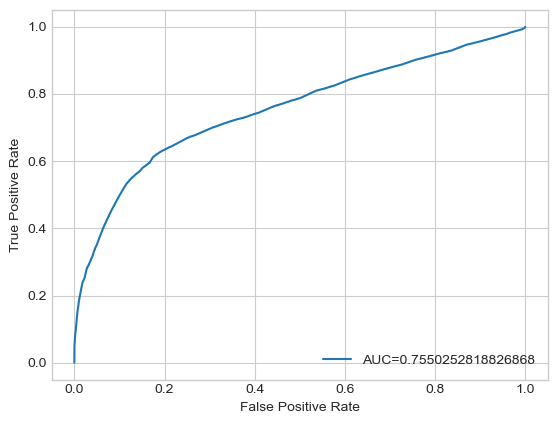

In [122]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test["push_opened"], test["preds"])
auc = roc_auc_score(test["push_opened"], test["preds"])
#create ROC curve
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

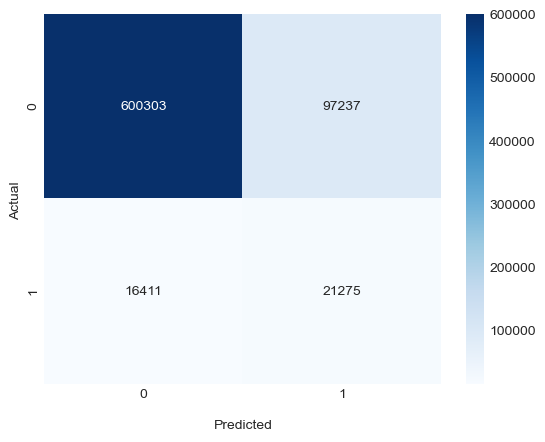

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
threshold = 0.08
cf_matrix = confusion_matrix(test["push_opened"], test["preds"] > threshold)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='')

ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [125]:
def get_top_k_recs(svd, user):
    list_hours = np.arange(0, 24)
    res = []
    for h in list_hours:
        res.append(svd.predict(user, h).est)
    return np.array(res).argmax()

In [126]:
%%time
from collections import defaultdict
from tqdm.notebook import tqdm
topn = defaultdict(list)
for u in tqdm(df.user_id.unique()):
    topn[u] = get_top_k_recs(algo, u)


CPU times: user 2min 13s, sys: 11 s, total: 2min 24s
Wall time: 2min 16s


In [127]:
pred_classes = list(topn.values())

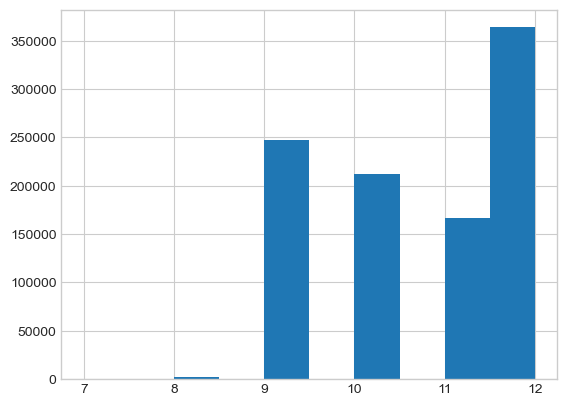

In [128]:
plt.hist(pred_classes);

Есть различные имплементации ускорения:
* funk-svd
* svd++

### Funk SVD 

In [133]:
%%time
from funk_svd import SVD
from sklearn.metrics import mean_absolute_error

svd = SVD(lr=0.0001, reg=0.01, n_epochs=100, n_factors=2,
          early_stopping=True, shuffle=False, min_rating=0, max_rating=1)

df['u_id'] = df['user_id']
df['i_id'] = df['hour']
df['rating'] = df['push_opened']
train = df[df.push_day < pd.to_datetime('2021-12-14')]\
                            [['u_id', 'i_id', 'rating']].drop_duplicates()

val = df[df.push_day == pd.to_datetime('2021-12-14')]\
                            [['u_id', 'i_id', 'rating']].drop_duplicates().reset_index(drop=True)

svd.fit(X=train, X_val=val)

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 0.05 - val_rmse: 0.22 - val_mae: 0.09 - took 0.8 sec
Epoch 2/100  | val_loss: 0.05 - val_rmse: 0.22 - val_mae: 0.09 - took 0.1 sec

Training took 6 sec
CPU times: user 11.5 s, sys: 784 ms, total: 12.3 s
Wall time: 12.8 s


In [134]:
pred = svd.predict(val)

In [135]:
from sklearn.metrics import precision_recall_fscore_support
threshold = 0.15
precision_recall_fscore_support(val['rating'], np.array(pred) > threshold, average='binary')

(0.37401574803149606, 0.06302075041129332, 0.1078662912162776, None)

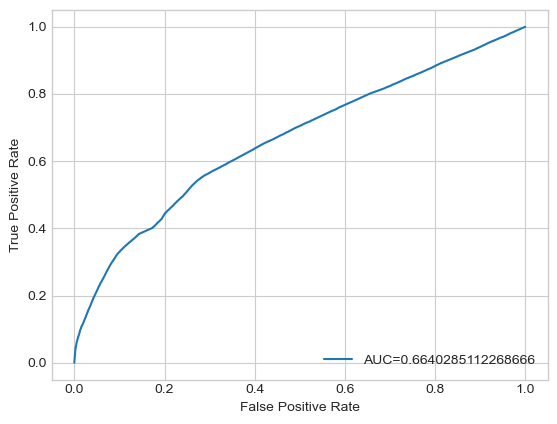

In [136]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(val['rating'],  pred)
auc = roc_auc_score(val['rating'],  pred)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

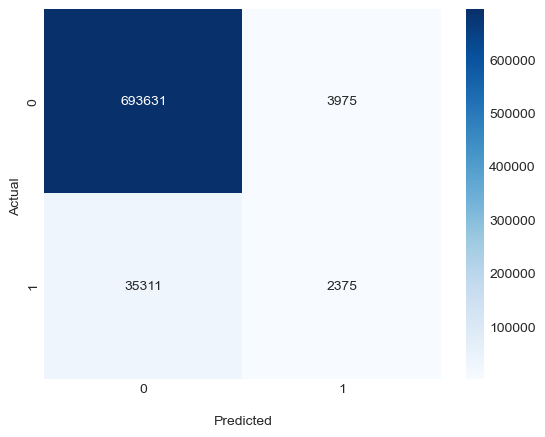

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(val['rating'], np.array(pred) > threshold)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='')

ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Display the visualization of the Confusion Matrix.
plt.show()

__Выводы__ :
* По качеству SVD surprise лучше классификаций
* По скорости обучения сравнимо с catboost, но есть много различных реализаций с ускорением процесса

Другие подходы к решению задачи
* Pairwise - триплеты из (пользователь, час открытия пуша, час неоткрытия пуша). Предложенные часы отправки пушей можно ранжировать по доле или количеству их открытия
* Неявный таргет - не доверять тому, что пользователь в конкретный день в конкретный час не открыл. Можно насемпилировать негативные случаи рандомно, не брать все сразу. Либо определить более точно отрицательный таргет - посмотрел превью и не перешел
* BPR-MF: Bayesian Personalized Ranking
* Двуэтапная модель: подбор кандидатов ALS, затем ранжирование бустингом
* LSTM https://mindbox.ru/journal/product/kak-opredelit-luchshuyu-datu-otpravki-email/
* Survival Analysis https://dl.acm.org/doi/abs/10.1145/3289600.3290981